In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
%cd /content/drive/My Drive/Colab Notebooks/Research/GazeSemgIntegration/more_features

/content/drive/My Drive/Colab Notebooks/Research/GazeSemgIntegration/more_features


In [8]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import lightgbm as ltb
from copy import deepcopy
import warnings


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

warnings.filterwarnings('ignore')

In [34]:
trainx = pd.read_csv('featured_data/step50ms/combined_trainx.csv')
trainy = pd.read_csv('featured_data/step50ms/combined_trainy.csv')
testx = pd.read_csv('featured_data/step50ms/combined_testx.csv')
testy = pd.read_csv('featured_data/step50ms/combined_testy.csv')

# plot the training data

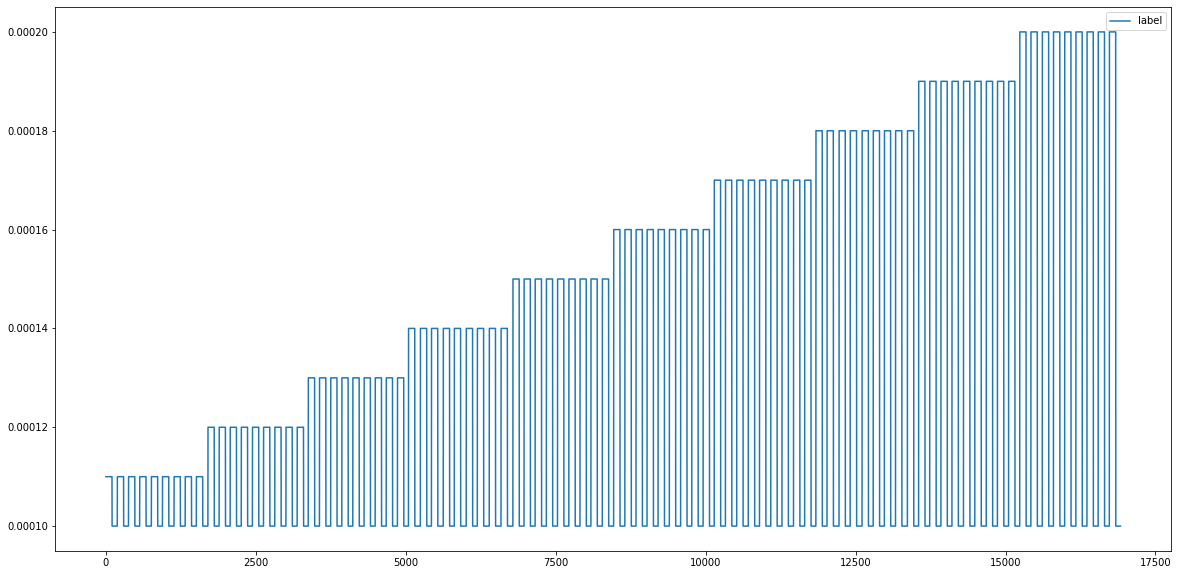

In [59]:
# index = np.array(trainx.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(trainy*0.00001+0.0001)
# for i in tqdm(range(0,12)):
#     ax.plot(index, trainx[i])
    
line1.set_label('label')
ax.legend()
plt.show();

# Plot the testing data

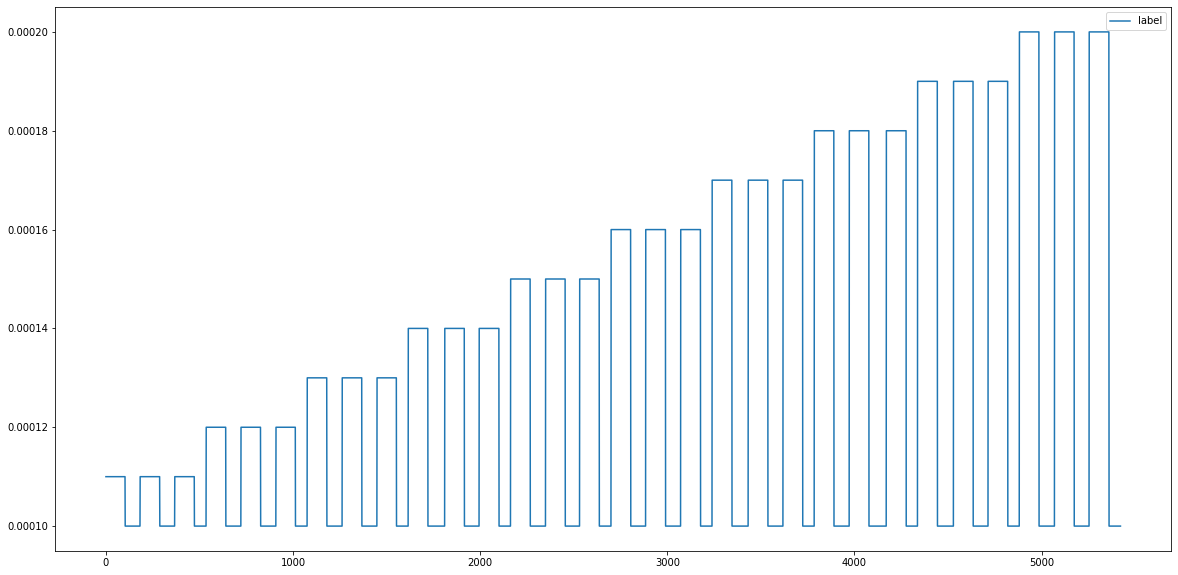

In [58]:
# index = np.array(testy.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(testy*0.00001+0.0001)
# for i in tqdm(range(0,12)):
#     ax.plot(index, trainx[i])
    
line1.set_label('label')
ax.legend()
plt.show();

# Find the transition zone test data

In [39]:
# find the fisrt 200ms which is 385 data point

# find the 30 start point
# ten_start_point is for the testing data set #2
counter = 0
label_number = [1,2,3,4,5,6,7,8,9,10]
checked_label = []
ten_start_point = []
for i in label_number:
    for j in range(0, len(testy)):
        if testy.iloc[j,0] == i:
            if i not in checked_label:
                counter += 1
                checked_label.append(i)
                ten_start_point.append(j)
        if counter == 10:
            break
            
# find the ten new end point
# ten_end_point is for the testing data set #2
last = 1
ten_end_point = []
label_number = [1,2,3,4,5,6,7,8,9,10]
for j in label_number:
    last = j
    counter = 0
    for i in tqdm(range(ten_start_point[j-1], len(testy))):
        if i == len(testy)-1:
            ten_end_point.append(i)
        current = testy.iloc[i,0]
        if last == current:
            last = current
        else:
            last = current
            counter += 1
        if counter == 1:
            ten_end_point.append(i)
            break
            
testx_t = testx.iloc[ten_start_point[0]:ten_start_point[0]+385, :]
testx_t = testx_t.append(testx.iloc[ten_end_point[0]:ten_end_point[0]+385, :])

for i in range(1,10):
#     if i == 9:
#         testx_t = testx_t.append(testx.iloc[ten_start_point[i]:ten_start_point[i]+385, :])
#         testx_t = testx_t.append(testx.iloc[ten_end_point[i]:220557, :])
#         break
    testx_t = testx_t.append(testx.iloc[ten_start_point[i]:ten_start_point[i]+385, :])
    testx_t = testx_t.append(testx.iloc[ten_end_point[i]:ten_end_point[i]+385, :])

testy_t = testy.iloc[ten_start_point[0]:ten_start_point[0]+385, :]
testy_t = testy_t.append(testy.iloc[ten_end_point[0]:ten_end_point[0]+385, :])

for i in range(1,10):
#     if i == 9:
#         testy_t = testy_t.append(testy.iloc[ten_start_point[i]:ten_start_point[i]+385, :])
#         testy_t = testy_t.append(testy.iloc[ten_end_point[i]:220557, :])
#         break
    testy_t = testy_t.append(testy.iloc[ten_start_point[i]:ten_start_point[i]+385, :])
    testy_t = testy_t.append(testy.iloc[ten_end_point[i]:ten_end_point[i]+385, :])

In [40]:
ten_start_point
ten_end_point

[0, 536, 1076, 1616, 2163, 2700, 3240, 3786, 4338, 4882]

[103, 641, 1181, 1721, 2268, 2805, 3346, 3891, 4444, 4987]

# Plot transition zone test data

In [55]:
testx_t

,0,1,2,3,4,5,6,7,8,9,10,11,0.1,1.1,2.1,3.1,4.1,5.1,6.1,7.1,8.1,9.1,10.1,11.1,0.2,1.2,2.2,3.2,4.2,5.2,6.2,7.2,8.2,9.2,10.2,11.2,0.3,1.3,2.3,3.3,...,8.4,9.4,10.4,11.4,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,0.6,1.6,2.6,3.6,4.6,5.6,6.6,7.6,8.6,9.6,10.6,11.6,0.7,1.7,2.7,3.7,4.7,5.7,6.7,7.7,8.7,9.7,10.7,11.7
0,0.000030,0.000046,0.000027,0.000030,0.000029,0.000007,0.000015,7.946580e-08,0.000048,0.000029,0.000021,0.000011,0.000030,0.000046,0.000027,0.000030,0.000028,0.000007,0.000015,7.975609e-08,0.000048,0.000029,0.000021,0.000011,0.006279,0.011084,0.007167,0.007751,0.007910,0.002054,0.002010,0.000019,0.011438,0.007512,0.004642,0.001992,0.000016,0.000029,0.000019,0.000020,...,0.005368,0.003109,0.002082,0.000912,3.495223e-07,8.282627e-07,2.863577e-07,3.369566e-07,3.128581e-07,2.073312e-08,8.232709e-08,2.455359e-12,8.735900e-07,3.165096e-07,1.739391e-07,4.288477e-08,0.000009,0.000013,0.000006,0.000007,0.000006,0.000002,0.000003,5.523310e-08,0.000014,0.000008,0.000005,0.000002,2.808033e-10,5.569885e-10,1.151818e-10,9.140494e-11,8.181301e-11,1.336500e-11,9.008756e-11,1.075720e-14,5.123136e-10,1.587403e-10,1.312907e-10,3.437288e-11
1,0.000033,0.000053,0.000029,0.000036,0.000026,0.000007,0.000015,8.349542e-08,0.000056,0.000032,0.000023,0.000013,0.000033,0.000053,0.000029,0.000036,0.000026,0.000007,0.000015,8.442154e-08,0.000056,0.000032,0.000023,0.000013,0.007758,0.014409,0.007970,0.009087,0.007250,0.001916,0.002423,0.000020,0.015105,0.008944,0.005335,0.002721,0.000020,0.000037,0.000021,0.000024,...,0.007382,0.003696,0.002274,0.001216,4.096648e-07,1.071680e-06,3.271227e-07,4.868581e-07,2.606020e-07,1.865206e-08,9.044671e-08,2.751021e-12,1.204735e-06,4.046495e-07,1.962190e-07,7.017013e-08,0.000011,0.000018,0.000007,0.000008,0.000006,0.000002,0.000003,6.001398e-08,0.000019,0.000010,0.000006,0.000003,3.417121e-10,7.751079e-10,1.402025e-10,1.679889e-10,7.813816e-11,1.313479e-11,9.301392e-11,1.229397e-14,7.714331e-10,2.011053e-10,1.366743e-10,4.536004e-11
2,0.000039,0.000062,0.000028,0.000033,0.000024,0.000005,0.000017,9.162478e-08,0.000070,0.000028,0.000013,0.000025,0.000039,0.000062,0.000028,0.000033,0.000024,0.000005,0.000017,9.303622e-08,0.000070,0.000028,0.000013,0.000025,0.010062,0.017093,0.006938,0.007469,0.005918,0.001420,0.003272,0.000022,0.018841,0.007104,0.003283,0.005233,0.000026,0.000044,0.000018,0.000019,...,0.009336,0.002988,0.001237,0.002551,5.793453e-07,1.493257e-06,2.959413e-07,4.257301e-07,2.162456e-07,8.779048e-09,1.086482e-07,3.341115e-12,1.896309e-06,3.120324e-07,7.002083e-08,2.452829e-07,0.000014,0.000022,0.000007,0.000007,0.000004,0.000002,0.000004,6.522983e-08,0.000024,0.000008,0.000003,0.000007,5.424950e-10,1.170697e-09,1.301506e-10,1.495877e-10,5.600416e-11,4.686912e-12,1.060105e-10,1.361119e-14,1.182344e-09,1.537952e-10,3.067727e-11,1.870994e-10
3,0.000038,0.000070,0.000019,0.000025,0.000019,0.000004,0.000021,1.010973e-07,0.000077,0.000020,0.000012,0.000028,0.000038,0.000069,0.000019,0.000025,0.000019,0.000004,0.000021,1.043061e-07,0.000077,0.000020,0.000012,0.000028,0.009958,0.019824,0.004677,0.004874,0.004058,0.001205,0.004360,0.000024,0.021267,0.004337,0.002580,0.006543,0.000026,0.000051,0.000012,0.000013,...,0.010950,0.001953,0.000982,0.003268,5.610752e-07,1.859975e-06,1.348847e-07,2.399626e-07,1.419767e-07,6.156706e-09,1.710023e-07,4.199590e-12,2.312041e-06,1.543501e-07,5.254339e-08,2.980987e-07,0.000014,0.000027,0.000005,0.000005,0.000003,0.000002,0.000005,7.175166e-08,0.000028,0.000005,0.000003,0.000008,5.337320e-10,1.582886e-09,6.417886e-11,1.063014e-10,3.955144e-11,4.204583e-12,1.359970e-10,1.661147e-14,1.561228e-09,7.724701e-11,2.137080e-11,2.351240e-10
4,0.000034,0.000066,0.000013,0.000022,0.000013,0.000003,0.000022,1.022580e-07,0.000083,0.000017,0.000010,0.000038,0.000034,0.000066,0.000013,0.000022,0.000013,0.000003,0.000021,1.048882e-07,0.000083,0.000017,0.000010,0.000038,0.008928,0.019004,0.002916,0.003570,0.002864,0.001073,0.004571,0.000024,0.022731,0.003367,0.002278,0.008590,0.000023,0.0000

KeyError: ignored

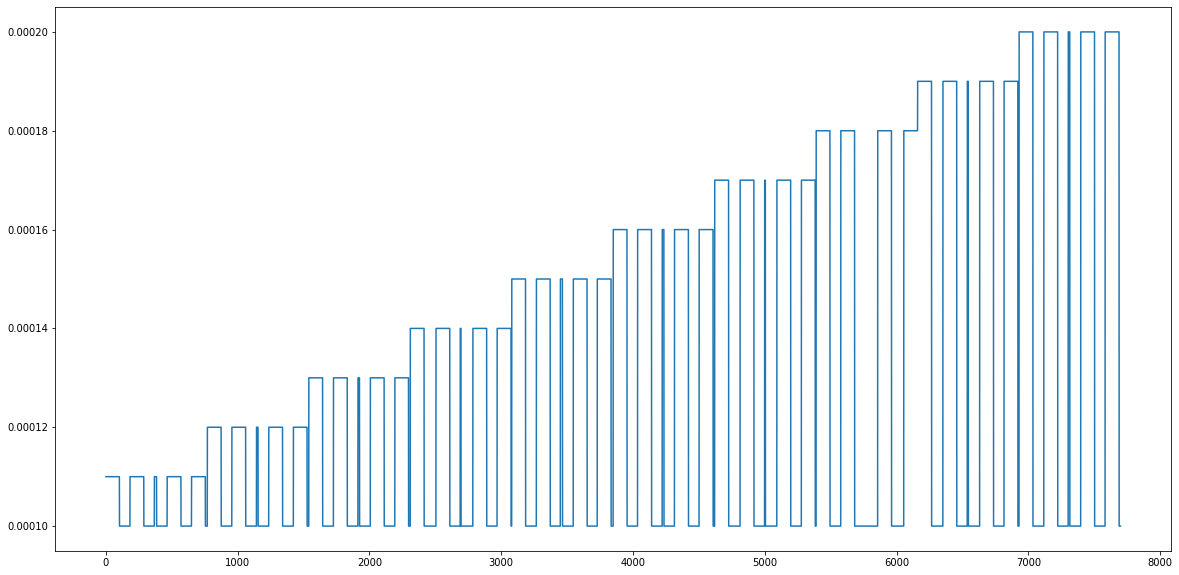

In [41]:
testx_t = testx_t.reset_index(drop = True)
testy_t = testy_t.reset_index(drop= True)

index = np.array(testx_t.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(testy_t*0.00001+0.0001)
for i in tqdm(range(0,12)):
    ax.plot(index, testx_t[i])
    
line1.set_label('label')
ax.legend()
plt.show();